In [1]:
#导入包
import anndata
print('anndata(Ver): ',anndata.__version__)
import scanpy as sc
print('scanpy(Ver): ',sc.__version__)
import matplotlib.pyplot as plt
import matplotlib
print('matplotlib(Ver): ',matplotlib.__version__)
import seaborn as sns
print('seaborn(Ver): ',sns.__version__)
import numpy as np
print('numpy(Ver): ',np.__version__)
import pandas as pd
print('pandas(Ver): ',pd.__version__)
import scvelo as scv
print('scvelo(Ver): ',scv.__version__)
import Pyomic
print('Pyomic(Ver): ',Pyomic.__version__)
import scvi
print('scvi(Ver): ',scvi.__version__)
import infercnvpy as cnv
print('infercnvpy(Ver): ',cnv.__version__)


#绘图参数设置
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, facecolor='white')

from matplotlib.colors import LinearSegmentedColormap
sc_color=['#7CBB5F','#368650','#A499CC','#5E4D9A','#78C2ED','#866017', '#9F987F','#E0DFED',
 '#EF7B77', '#279AD7','#F0EEF0', '#1F577B', '#A56BA7', '#E0A7C8', '#E069A6', '#941456', '#FCBC10',
 '#EAEFC5', '#01A0A7', '#75C8CC', '#F0D7BC', '#D5B26C', '#D5DA48', '#B6B812', '#9DC3C3', '#A89C92', '#FEE00C', '#FEF2A1']
sc_color_cmap = LinearSegmentedColormap.from_list('Custom', sc_color, len(sc_color))

anndata(Ver):  0.8.0
scanpy(Ver):  1.9.1
matplotlib(Ver):  3.6.2
seaborn(Ver):  0.12.1
numpy(Ver):  1.23.2
pandas(Ver):  1.3.5
scvelo(Ver):  0.2.5
Pyomic(Ver):  1.1.7


Global seed set to 0


scvi(Ver):  0.20.1
infercnvpy(Ver):  0.4.0


In [2]:
import argparse, os, sys
from os import listdir
from os.path import isfile, join

import pickle
import math
import collections
import time

import numpy as np
import pandas as pd
import scanpy as sc
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import silhouette_score
import multiprocess as mp
from functools import partial

import kaplanmeier as km
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [3]:
adata=sc.read('crc_rna_infercnv.h5ad')
adata

AnnData object with n_obs × n_vars = 42546 × 24708
    obs: 'SRR', 'Cancer', 'site', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'major_celltype', 'cnv_leiden', 'cnv_score', 'cnv_status'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'hgnc_id', 'havana_gene', 'tag', 'chromosome', 'start', 'end', 'gene_name'
    uns: 'SRR_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cnv', 'cnv_leiden_colors', 'cnv_neighbors', 'cnv_status_colors', 'cosg', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'major_celltype_colors', 'neighbors', 'paga', 'rank_genes_groups', 'umap'
    obsm: 'X_cnv', 'X_cnv_pca', 'X_cnv_umap', 'X_pca', 'X_scVI', 'X_umap'
    obsp: 'cnv_neighbors_co

In [4]:
tumor=adata[adata.obs['cnv_status']=='tumor']
tumor=tumor.raw.to_adata()
tumor

AnnData object with n_obs × n_vars = 9889 × 24708
    obs: 'SRR', 'Cancer', 'site', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', '_scvi_batch', '_scvi_labels', 'leiden', 'major_celltype', 'cnv_leiden', 'cnv_score', 'cnv_status'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'SRR_colors', '_scvi_manager_uuid', '_scvi_uuid', 'cnv', 'cnv_leiden_colors', 'cnv_neighbors', 'cnv_status_colors', 'cosg', 'dendrogram_leiden', 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'major_celltype_colors', 'neighbors', 'paga', 'rank_genes_groups', 'umap'
    obsm: 'X_cnv', 'X_cnv_pca', 'X_cnv_umap', 'X_pca', 'X_scVI', 'X_umap'
    obsp: 'cnv_neighbors_connectivities', 'cnv_neighbors_distances', 'connectivities', 'distances'

In [5]:
adata=tumor
print('Preprocessing...')
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
if not (adata.obs.pct_counts_mt == 0).all():
    adata = adata[adata.obs.pct_counts_mt < 30, :]
sc.pp.normalize_total(adata, target_sum=1e4)
adata.raw = adata.copy()
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')

Preprocessing...
filtered out 2051 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


In [6]:
sc.pp.neighbors(adata, n_pcs=20)
sc.tl.umap(adata)


computing neighbors
    using 'X_pca' with n_pcs = 20


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:12)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:09)


In [ ]:
Pyomic.utils.download_GDSC_data()
Pyomic.utils.download_CaDRReS_model()

Automatically determine clustering resolution...
Clustering test: resolution =  0.4
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 15 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 16 clusters and added
    'louvain', the cluster labels (adata.obs, categoric

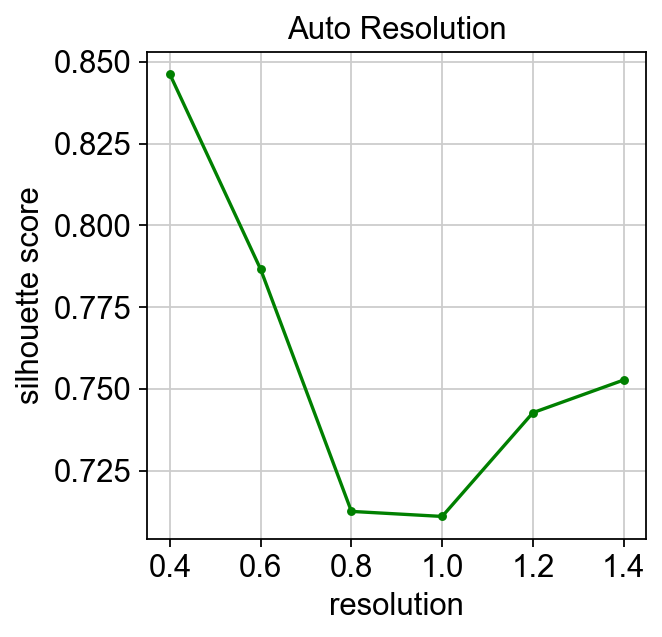

In [8]:
adata, res,plot_df = Pyomic.single.autoResolution(adata,cpus=4)

In [ ]:
results_file = os.path.join('tutorial', 'scanpyobj.h5ad')
adata.write(results_file)

In [1]:
import scanpy as sc
import os
results_file = os.path.join('./', 'scanpyobj.h5ad')
adata=sc.read(results_file)


In [2]:
!pwd

/Users/fernandozeng/Desktop/Pyomic/tutorial


In [4]:
import Pyomic
job=Pyomic.single.Drug_Response(adata,scriptpath='/Users/fernandozeng/Desktop/analysis/CaDRReS-Sc',
                                modelpath='/Users/fernandozeng/Desktop/Pyomic/models/',
                                output='result')

Calculating kernel features based on 14980 common genes
(22657, 14) (17419, 1018)
Predicting drug response for using CaDRReS(GDSC): cadrres-wo-sample-bias
done!
Ploting...
done!
